In [1]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import time
import sqlite3
import pandas as pd
from scipy.interpolate import interp1d
import random 
import itertools
from datetime import datetime
from scipy import interp
from scipy.interpolate import RegularGridInterpolator
plt.style.use('ggplot')

## Datas 

In [2]:
PATH_DATA = '/Users/mathildebadoual/code/ev_controller/data/'
PATH_REPORT = '/Users/mathildebadoual/code/ev_controller/report/'

In [3]:
data = pd.read_csv(PATH_DATA + 'price_demand.csv')
data.max()

Year       2015.000
Month        12.000
day          31.000
Hour         24.000
Demand    23169.960
Price       187.891
dtype: float64

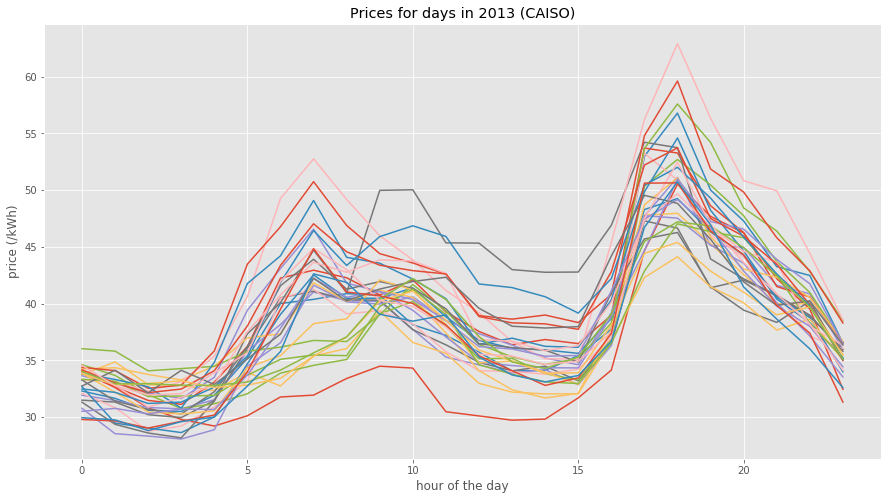

In [4]:
plt.figure(figsize=(15, 8))
for day in range(1, 31):
    for month in range(1, 2):
        plt.plot(range(0, 24), data[(data['day'] == day) & (data['Month'] == month) & (data['Year'] == 2013)]['Price'])
plt.xlabel('hour of the day')
plt.ylabel('price (/kWh)')
plt.title('Prices for days in 2013 (CAISO)')
plt.savefig(PATH_REPORT + 'prices_day.png')

In [5]:
def satisfaction_function(x):
    return c * (1 - np.exp(alpha * (1 - x)))/(1 - np.exp(alpha))

## Markov Chain: EV data

In [6]:
data_ev = pd.read_csv(PATH_DATA + 'EV_data.csv')
ID_26 = data_ev['ID:26']     #Car_ID:26
ID_370 = data_ev['ID:370']   #Car_ID:370
ID_545 = data_ev['ID:545']   #Car_ID:545
ID_661 = data_ev['ID:661']   #Car_ID:661
ID_4767 = data_ev['ID:4767'] #Car_ID:4767

#Creating and resizing EV_array into (ID , Week, DOW, HOD)
ev_array = np.array([ID_26, ID_370, ID_545, ID_661, ID_4767])
ev_array.resize(5,47,7,24)

In [7]:
array = np.zeros((len(data.columns[1:])*len(data_ev), 5))
j = 0
for car_index, car in enumerate(data_ev.columns[1:]):
    for i in range(len(data_ev)):
        value = datetime.strptime(data_ev['localminute'].iloc[i], '%m/%d/%Y %H:%M')
        week_of_year = int(value.strftime('%W'))
        day_of_week = int(value.strftime('%w'))
        hour_of_day = int(value.strftime('%H'))
        array[j, :] = [car_index, week_of_year, day_of_week, hour_of_day, data_ev[car].iloc[i]]
        j += 1
        
data_ev_resized = pd.DataFrame(array, columns=['car_index', 'week_of_year', 'day_of_week', 'hour_of_day', 'energy_consumption'])

In [8]:
presence_list = []
for element in data_ev_resized['energy_consumption']:
    if element <= 0.01:
        presence_list.append(0)
    else:
        presence_list.append(1)
        
data_ev_resized['presence'] = presence_list


In [9]:
#Creating Markov chain!
#Considering (5 x 47 x 7 ) different data arrays, we find the probablility
#matrix pij(k), i for charging, j for not charging.
#At each time step we count the 
p_list =[ ]  #initializing list containing the probability matrices
for k in range(23):  # 23 cuz probability doesn't count for last timestep
    Num_charging = [0, 0, 0]     #[num_charging now, num_STILL charging at k+1, num_n0t charging at k+1]
    Num_not_charging = [0, 0, 0] #[num_not charging now, num_charging next k, num STILL not charging next k]
    for j in range(47):
        for v in range(7):
            if any(i >= 0.3 for i in ev_array[:,j,v,k]): #I use 0.3 as charging benchmark
                Num_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_charging[1] += 1
                else:
                    Num_charging[2] += 1
            else:
                Num_not_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_not_charging[1] += 1
                else:
                    Num_not_charging[2] += 1
    p_ij = np.zeros((2,2))
    p_ij[0,0] = Num_charging[1]/Num_charging[0]  #probability of moving from i to i
    p_ij[0,1] = Num_charging[2]/Num_charging[0]  #probability of moving from i to j
    p_ij[1,0] = Num_not_charging[1]/Num_not_charging[0] 
    p_ij[1,1] = Num_not_charging[2]/Num_not_charging[0]
    p_list.append(p_ij)
    

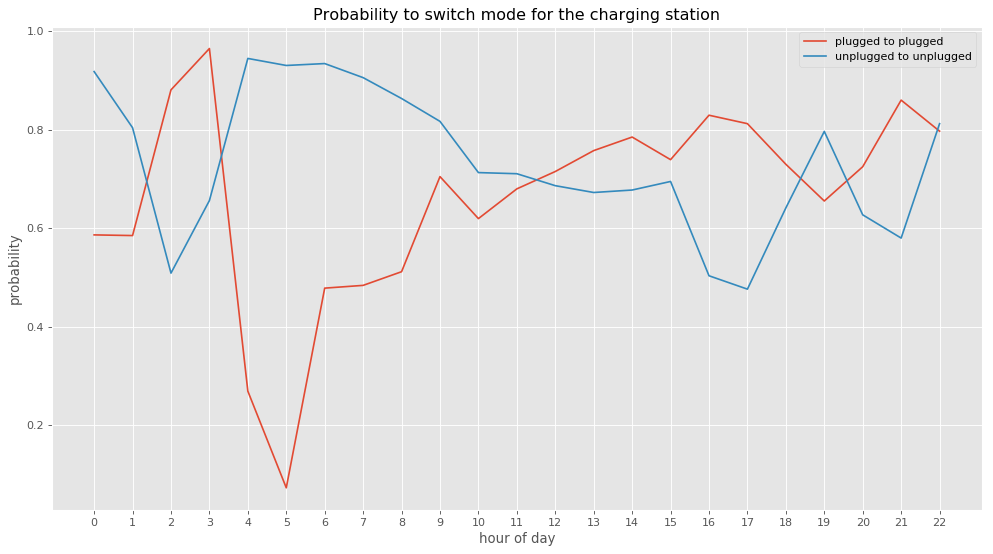

In [10]:
P = np.array(p_list)
fs = 14

plt.figure(dpi = 80, figsize = (15,8), tight_layout = False)
plt.plot(np.linspace(0,22,23), P[:,0,0], label = 'plugged to plugged')
plt.plot(np.linspace(0,22,23), P[:,1,1], label = 'unplugged to unplugged')
plt.xticks(np.linspace(0,22,23))
plt.ylabel('probability', fontsize = fs-2)
plt.xlabel('hour of day', fontsize = fs-2)
plt.title('Probability to switch mode for the charging station')
plt.legend()
plt.show()
plt.savefig(PATH_REPORT + 'probability_switch_station.png')

## Regular DeterministicControl

In [28]:
## SET PARAMETERS
num_station = 2
ns = 10

N = 24
c = 100
alpha = 0.003
delta_t = 1
u_max = 0.3
U_max = 0.45

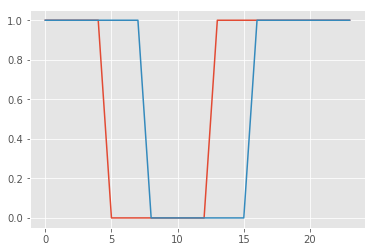

In [29]:
## GET DATA
prices_day = data[(data['day'] == 1) & (data['Month'] == 1) & (data['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
prices = np.flip(prices_interp(np.linspace(0, 23, N)), axis=0)

presence = np.zeros((num_station, 24))
#presence[i, :] = data_ev_resized[(data_ev_resized['car_index'] == 1) & (data_ev_resized['day_of_week'] == i+1) & (data_ev_resized['week_of_year'] == 15)]['presence']
presence[0, :] = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
presence[1, :] = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
plt.plot(presence[0, :])
plt.plot(presence[1, :])

In [59]:
SOC_shape = tuple([ns for i in range(num_station)])   # This creates a tuple is needed to for any np.reshape operation later

SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), repeat = num_station))) # repeat added...

SOC_tuple = tuple([np.linspace(0,1,ns) for i in range(num_station)])  # This is needed for the interpolation later

In [60]:
u_star = np.zeros((num_station, len(SOC_grid), N))
V = 100000 * np.ones((len(SOC_grid), N+1))

In [61]:
## SOLVE DYNAMIC PROGRAM
start = time.time()

# Boundary Condition of Value Function (Principle of Optimality)

V[-1,N] = 0     #This ensures that the progam only accepts SOC of 1 for all stations at time N.

# Iterate backward in time
for k in range(N-1, 0, -1):

    # Iterate over SOC
    for idx in range(0, len(SOC_grid)):

        # Find dominant bounds for u_batt
        lb = 0
        ub = [min(u_max, (1.0 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
        
        # Grid Battery Power between dominant bounds
        u_batt_init = np.array(list(itertools.product(np.linspace(lb, ub[0], ns), np.linspace(lb, ub[1], ns)))) #initializing u_batt
        #for i in range(num_station):
        #    u_batt_init[:,i] = u_batt_init[:,i] * (ub[i] / u_max)  #This ensures that the upperbounds are respected if ub < u_max
        
        u_batt_delete = []            # This list is used to delete u_batt values that break the u_max constraint
        for i in range(len(u_batt_init)):
            if u_batt_init[i].sum() > U_max:
                u_batt_delete.append(i)
            
        u_batt_grid = np.delete(u_batt_init, u_batt_delete, 0)  #This is the real u_batt_grid used in the rest of the code
        #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
        # compute next SOC using dynamics
        SOC_nxt = SOC_grid[idx] + delta_t * u_batt_grid
        
        # Cost (no satisfaction)
        satisfaction_k = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
        g_k = prices[k] * u_batt_grid.sum(axis = 1) + satisfaction_k
        
        # Compute value function at nxt time step (need to interpolate)
        V_nxt = 100000*np.ones((len(SOC_nxt),1))
        V_temp = V[:,k+1].reshape(SOC_shape)      #V[k+1] has to be reshaped to work in interpolation
        V_interp_function = RegularGridInterpolator(SOC_tuple, V_temp, method = 'linear')  #n-dimensional interpolation function
        
        V_nxt = V_interp_function(SOC_nxt)

        
        # Value Function (Principle of Optimality)
        V[idx, k] = (delta_t * g_k + V_nxt.T).min()
        ind = np.argmin(delta_t * g_k + V_nxt.T)
        
        # Save Optimal Control
        u_star[:, idx, k] = u_batt_grid[ind]
        
# DP Timer
end = time.time()
print(str(end - start) + " seconds")

3.9533541202545166 seconds


In [62]:
## Simulate Results

random.seed(10)

# Preallocate
SOC_sim = np.zeros((num_station, N))
u_batt_sim = np.zeros((num_station, N))
J_sim = np.zeros((N))

# Initialize
SOC_0 = np.array([0.2, 0.3])
SOC_sim[:, 0] = SOC_0

# Simulate PHEV Dynamics
for k in range(0, N-1):
    
#     # Use optimal battery power, for given SOC
#     u_batt_sim[:, k] = np.reshape(interp(SOC_sim[:, k].flatten(), SOC_grid.flatten(), u_star[:, :, k].flatten()), (num_station,))
#     for i in range(num_station):
#         u_batt_sim[i, k] = presence[i, k] * u_batt_sim[i, k]
    
    # Use optimal battery power, for given SOC
    for i in range(num_station):
        u_temp_sim = u_star[i,:,k].reshape(SOC_shape)
        u_interp_func= RegularGridInterpolator(SOC_tuple, u_temp_sim, method = 'linear') 
        u_batt_sim[i, k] = presence[i,k] * u_interp_func(SOC_sim[:,k])      #interpolation necessary for selectign each element of u_batt_sim!
        
    # Fuel Consumption
    satisfaction_k = np.sum(c * (1 - np.exp(alpha * (1 - SOC_sim[:, k])))/(1 - np.exp(alpha)))
    J_sim[k] = prices[k] * np.sum(u_batt_sim[:, k]) + satisfaction_k
    
    
    # Time-step SOC dynamics
    SOC_sim[:, k+1] = (SOC_sim[:, k] + delta_t * u_batt_sim[:, k]) 
    
    for i in range(num_station):
        if presence[i, k] == 0 and presence[i, k+1] == 1:
            print('switch')
            SOC_sim[i, k+1] = 0.3
            #SOC_sim[i, k+1] = random.uniform(0, 1)
        else:
            SOC_sim[i, k+1] = presence[i, k] * SOC_sim[i, k+1]

switch
switch


Total cost of charging vehicles =  2307.491034260797 USD


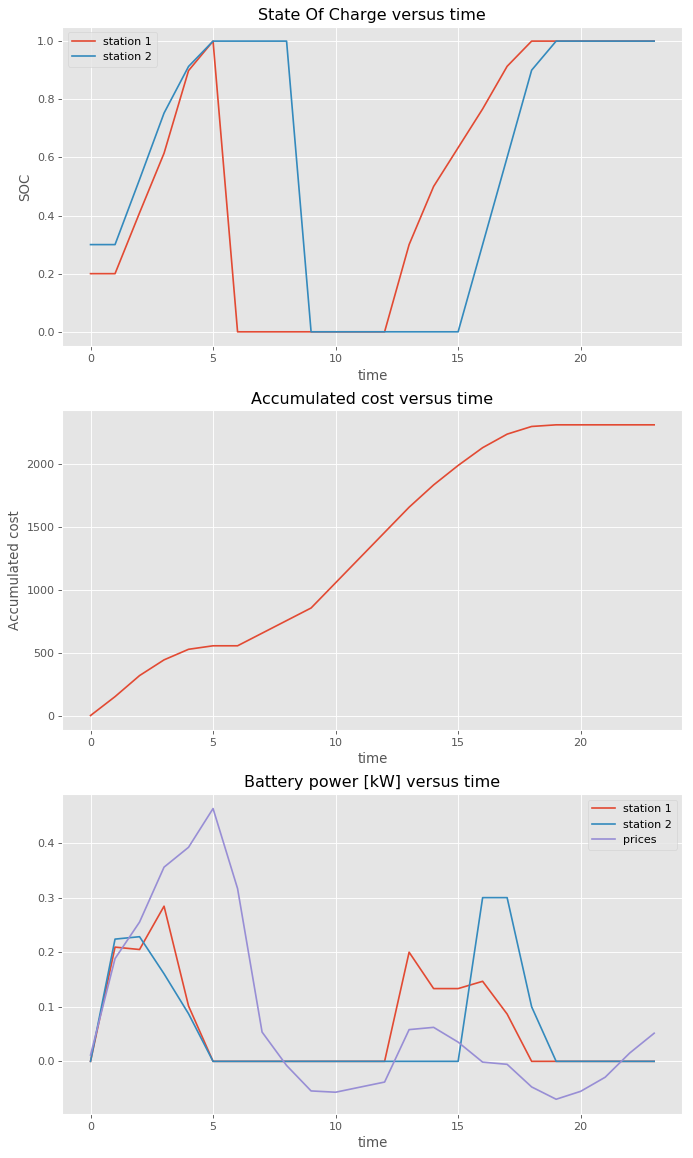

In [63]:
t = np.linspace(0, 23, N)

## Plot Simulation Results
plt.figure(num=3, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.plot(t, SOC_sim[0], label='station 1')  
plt.plot(t, SOC_sim[1], label='station 2') 
#plt.plot(t, SOC_sim[2], label='station 3')  
plt.title('State Of Charge versus time')
plt.xlabel('time')
plt.ylabel('SOC')
plt.legend()
# SOC versus time

plt.subplot(3,1,2)
plt.plot(t, [np.sum(J_sim[:k]) for k in range(0, N)])  # plot speed
plt.title('Accumulated cost versus time')
plt.xlabel('time')
plt.ylabel('Accumulated cost')
# Accumulated fuel consumption [g] versus time

plt.subplot(3,1,3)
plt.plot(t, u_batt_sim[0], label='station 1')  
plt.plot(t, u_batt_sim[1], label='station 2') 
#plt.plot(t, u_batt_sim[2], label='station 3') 
plt.plot(t, prices/40 - 0.8, label='prices')
plt.title('Battery power [kW] versus time')
plt.xlabel('time')
plt.legend()
# Battery and engine power [kW] versus time

plt.savefig(PATH_REPORT + 'results_deterministic.png')
print ("Total cost of charging vehicles = ", J_sim.sum(), "USD")

## Stochastic Control

In [52]:
## SET PARAMETERS
num_station = 2
ns = 10

N = 24
c = 100
alpha = 0.003
delta_t = 1
u_max = 0.3
U_max = 0.45

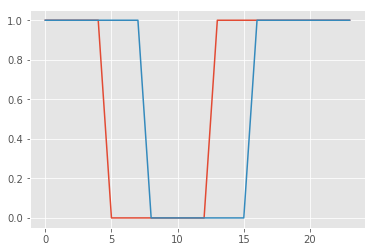

In [53]:
## GET DATA
prices_day = data[(data['day'] == 1) & (data['Month'] == 1) & (data['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
#prices = prices_interp(np.linspace(0, 23, N))
prices = np.flip(prices_interp(np.linspace(0, 23, N)), axis=0)

presence = np.zeros((num_station, 24))
#presence[i, :] = data_ev_resized[(data_ev_resized['car_index'] == 1) & (data_ev_resized['day_of_week'] == i+1) & (data_ev_resized['week_of_year'] == 15)]['presence']
presence[0, :] = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
presence[1, :] = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
plt.plot(presence[0, :])
plt.plot(presence[1, :])

In [54]:
SOC_shape = tuple([ns for i in range(num_station)])   # This creates a tuple is needed to for any np.reshape operation later

SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), repeat = num_station))) # repeat added...

SOC_tuple = tuple([np.linspace(0,1,ns) for i in range(num_station)])  # This is needed for the interpolation later

In [55]:
u_star = np.zeros((num_station, len(SOC_grid), N))
V = 10000000 * np.ones((len(SOC_grid), N+1))
V[ :, N] = satisfaction_function(SOC_grid[:,0]) #+ satisfaction_function(SOC_grid[:,1])

In [56]:
## SOLVE DYNAMIC PROGRAM
start = time.time()

# Boundary Condition of Value Function (Principle of Optimality)
# V[:, :, N] = np.zeros((num_station, len(SOC_grid)))

# Iterate backward in time
for k in range(N-1, 0, -1):

    # Iterate over SOC
    for idx in range(0, len(SOC_grid)):

        # Find dominant bounds for u_batt
        # Find dominant bounds for u_batt
        lb = 0
        ub = [min(u_max, (1.0 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
        
        # Grid Battery Power between dominant bounds
        u_batt_init = np.array(list(itertools.product(np.linspace(lb, ub[0], ns), np.linspace(lb, ub[1], ns)))) #initializing u_batt
        u_batt_init = u_batt_init * ub/u_max  #This ensures that the upperbounds are respected if ub < u_max
        
        u_batt_delete = []            # This list is used to delete u_batt values that break the u_max constraint
        for i in range(len(u_batt_init)):
            if u_batt_init[i].sum() > U_max:
                u_batt_delete.append(i)
            
        u_batt_grid = np.delete(u_batt_init, u_batt_delete, 0) 
        #This is the real u_batt_grid used in the rest of the code
        #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
        # compute next SOC using dynamics
        SOC_nxt_00 = 0 * u_batt_grid
        SOC_nxt_11 = SOC_grid[idx] + delta_t * u_batt_grid
        SOC_nxt_01 = random.uniform(0, 1) * np.ones(u_batt_grid.shape)# tbd
        SOC_nxt_10 = 0 * u_batt_grid
        
        # Cost of satisfaction
        satisfaction_k_0 = np.zeros((u_batt_grid.shape[0]))
        satisfaction_k_1 = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_grid[idx])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
        #satisfaction_k_01 = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt_01[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
        #satisfaction_k_10 = np.zeros((u_batt_grid.shape[0]))
        g_k_00 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_0
        g_k_11 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_1
        g_k_01 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_1
        g_k_10 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_0
            
        if k == 23:
            g_k = g_k_11
        else:
            g_k = P[k, 0, 0] * g_k_00 + P[k, 1, 1] * g_k_11 + P[k, 0, 1] * g_k_01 + P[k, 1, 0] * g_k_10
                
        # Compute value function at nxt time step (need to interpolate)
        
        V_nxt_init = 10000000*np.ones((len(SOC_nxt),1)) #initializing V_nxt
        V_temp = V[:,k+1].reshape(SOC_shape)      #V[k+1] has to be reshaped to work in interpolation
        V_interp_function = RegularGridInterpolator(SOC_tuple, V_temp, method = 'linear')  #n-dimensional interpolation function
        
        V_nxt_00 = V_interp_function(SOC_nxt_00)
        V_nxt_11 = V_interp_function(SOC_nxt_11)
        V_nxt_01 = V_interp_function(SOC_nxt_01)
        V_nxt_10 = V_interp_function(SOC_nxt_10)
                
        if k == 23:
            V_nxt = V_nxt_11
        else:
            V_nxt = P[k, 0, 0] * V_nxt_00 + P[k, 1, 1] * V_nxt_11 + P[k, 0, 1] * V_nxt_01 + P[k, 1, 0] * V_nxt_10
        
        # Value Function (Principle of Optimality)
        V[idx, k] = (delta_t * g_k + V_nxt).min()
        ind = np.argmin(delta_t * g_k + V_nxt)
        
        # Save Optimal Control
        u_star[:, idx, k] = u_batt_grid[ind]
        
# DP Timer
end = time.time()
print(str(end - start) + " seconds")

7.533302068710327 seconds


In [57]:
## Simulate Results

random.seed(10)

# Preallocate
SOC_sim = np.zeros((num_station, N))
u_batt_sim = np.zeros((num_station, N))
J_sim = np.zeros((N))

# Initialize
SOC_0 = np.array([0.2, 0.3])
SOC_sim[:, 0] = SOC_0

# Simulate PHEV Dynamics
for k in range(0, N-1):
    
#     # Use optimal battery power, for given SOC
#     u_batt_sim[:, k] = np.reshape(interp(SOC_sim[:, k].flatten(), SOC_grid.flatten(), u_star[:, :, k].flatten()), (num_station,))
#     for i in range(num_station):
#         u_batt_sim[i, k] = presence[i, k] * u_batt_sim[i, k]
    
    # Use optimal battery power, for given SOC
    for i in range(num_station):
        u_temp_sim = u_star[i,:,k].reshape(SOC_shape)
        u_interp_func= RegularGridInterpolator(SOC_tuple, u_temp_sim, method = 'linear') 
        u_batt_sim[i, k] = presence[i,k] * u_interp_func(SOC_sim[:,k])      #interpolation necessary for selectign each element of u_batt_sim!
        
    # Fuel Consumption
    satisfaction_k = np.sum(c * (1 - np.exp(alpha * (1 - SOC_sim[:, k])))/(1 - np.exp(alpha)))
    J_sim[k] = prices[k] * np.sum(u_batt_sim[:, k]) + satisfaction_k
    
    
    # Time-step SOC dynamics
    SOC_sim[:, k+1] = (SOC_sim[:, k] + delta_t * u_batt_sim[:, k])
    
    for i in range(num_station):
        if presence[i, k] == 0 and presence[i, k+1] == 1:
            print('switch')
            SOC_sim[i, k+1] = 0.3
            #SOC_sim[i, k+1] = random.uniform(0, 1)
        else:
            SOC_sim[i, k+1] = presence[i, k] * SOC_sim[i, k+1]

switch
switch


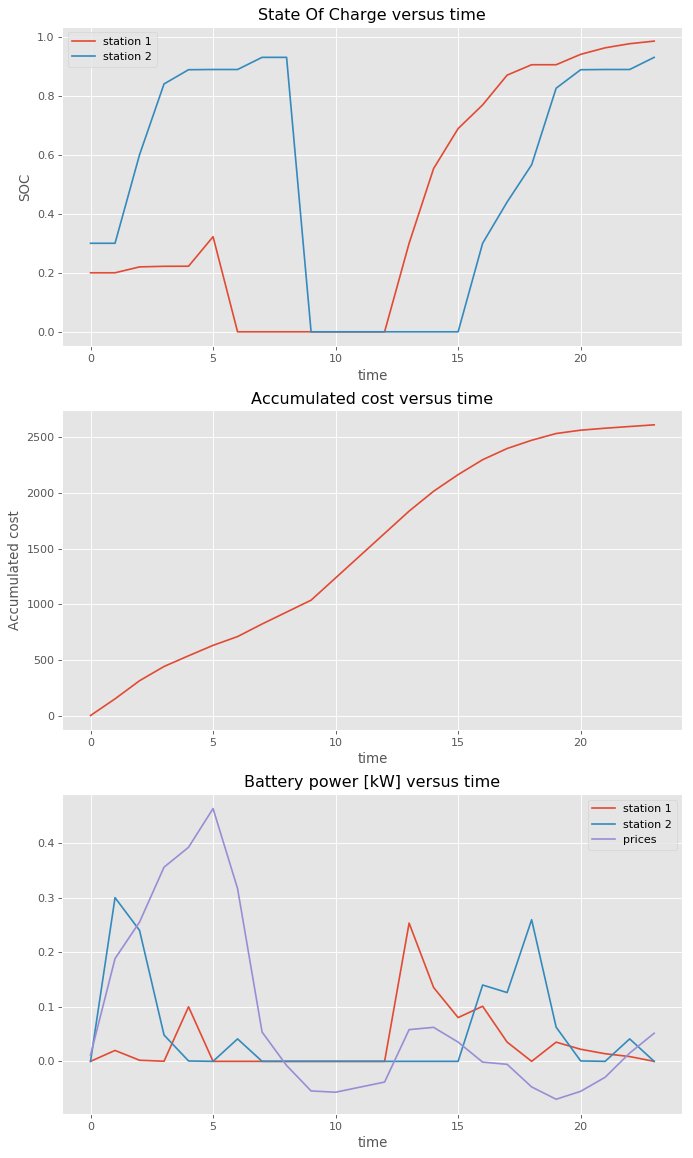

In [58]:
t = np.linspace(0, 23, N)

## Plot Simulation Results
plt.figure(num=3, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.plot(t, SOC_sim[0], label='station 1')  
plt.plot(t, SOC_sim[1], label='station 2') 
#plt.plot(t, SOC_sim[2], label='station 3')  
plt.title('State Of Charge versus time')
plt.xlabel('time')
plt.ylabel('SOC')
plt.legend()
# SOC versus time

plt.subplot(3,1,2)
plt.plot(t, [np.sum(J_sim[:k]) for k in range(0, N)])  # plot speed
plt.title('Accumulated cost versus time')
plt.xlabel('time')
plt.ylabel('Accumulated cost')
# Accumulated fuel consumption [g] versus time

plt.subplot(3,1,3)
plt.plot(t, u_batt_sim[0], label='station 1')  
plt.plot(t, u_batt_sim[1], label='station 2') 
#plt.plot(t, u_batt_sim[2], label='station 3') 
plt.plot(t, prices/40 - 0.8, label='prices')
plt.title('Battery power [kW] versus time')
plt.xlabel('time')
plt.legend()
# Battery and engine power [kW] versus time

plt.savefig(PATH_REPORT + 'results_stochastic.png')

## Tests